## **<h3 align="center"> Deep Learning - Project </h3>**
# **<h3 align="center"> Phylum Cnidaria</h3>**
**Group 4 members:**<br>
Alexandra Pinto - 20211599@novaims.unl.pt - 20211599<br>
Steven Carlson - 20240554@novaims.unl.pt - 20240554<br>
Sven Goerdes - 20240503@novaims.unl.pt - 20240503<br>
Tim Straub - 20240505@novaims.unl.pt - 20240505<br>
Zofia Wojcik  - 20240654@novaims.unl.pt - 20240654<br>

# Table of Contents
* [1. Introduction](#intro)
* [2. Setup](#setup)
* [3. Data Loading](#dataloading)
* [4. Image Preprocessing](#imagepreprocessing)
* [5. Neural Networks Models](#nnmodels)



# 1. Introduction <a class="anchor" id="intro"></a>

In this third notebook, we will preprocess images from the **Chordata** phylum and develop a deep learning model to accurately classify them at the family level.

# 2. Setup <a class="anchor" id="setup"></a>
In this section, we will import the necessary libraries that will be used throughout the notebook. These libraries will help with data handling and image processing.

In [2]:
# Standard libraries
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for image processing
from glob import glob
from PIL import Image
import cv2

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Progress bar
from tqdm.auto import tqdm


# 3. Data Loading <a class="anchor" id="dataloading"></a>

Let's open the train and test for Chordata Phylum.

In [3]:
# Load the DataFrame from the CSV file
cnidaria_train = pd.read_pickle("train_test_splits/cnidaria_train_processed.pkl")
cnidaria_train.head(3)

eol_content_id  eol_page_id   kingdom    phylum          family  \
0        28219388     45276311  animalia  cnidaria     acroporidae   
1        29729570     45276321  animalia  cnidaria     acroporidae   
2        20332243     46545536  animalia  cnidaria  lobophylliidae   

                                           file_path  \
0  cnidaria_acroporidae/28219388_45276311_eol-ful...   
1  cnidaria_acroporidae/29729570_45276321_eol-ful...   
2  cnidaria_lobophylliidae/20332243_46545536_eol-...   

                                       resized_image  \
0  [[[76, 74, 71], [73, 70, 71], [74, 71, 72], [7...   
1  [[[202, 202, 170], [195, 186, 156], [209, 197,...   
2  [[[8, 159, 90], [9, 183, 111], [2, 212, 128], ...   

                                         clahe_image  \
0  [[[72, 70, 67], [57, 53, 54], [58, 56, 57], [8...   
1  [[[157, 157, 126], [135, 128, 100], [158, 149,...   
2  [[[0, 78, 19], [0, 113, 49], [0, 185, 103], [0...   

                                  noBackground_image  has_black_background  \
0  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...                 False   
1  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...                 False   
2  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...                 False   

                                         mixed_image  
0  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  
1  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  
2  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...

In [4]:
# Load the DataFrame from the CSV file
cnidaria_test = pd.read_pickle("train_test_splits/cnidaria_test_processed.pkl")
cnidaria_test.head(3)

eol_content_id  eol_page_id   kingdom    phylum          family  \
0        21699228     45276518  animalia  cnidaria     agariciidae   
1         2746810     45276959  animalia  cnidaria  siderastreidae   
2        29729172     45276583  animalia  cnidaria       fungiidae   

                                           file_path  \
0  cnidaria_agariciidae/21699228_45276518_eol-ful...   
1  cnidaria_siderastreidae/2746810_45276959_eol-f...   
2  cnidaria_fungiidae/29729172_45276583_eol-full-...   

                                       resized_image  \
0  [[[81, 148, 190], [83, 150, 192], [84, 151, 19...   
1  [[[192, 220, 224], [193, 221, 225], [193, 221,...   
2  [[[128, 147, 84], [49, 62, 51], [50, 61, 71], ...   

                                         clahe_image  \
0  [[[85, 152, 193], [94, 160, 202], [94, 160, 20...   
1  [[[122, 147, 151], [124, 149, 153], [124, 149,...   
2  [[[183, 203, 137], [12, 25, 14], [15, 27, 36],...   

                                  noBackground_image  has_black_background  \
0  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...                  True   
1  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...                 False   
2  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...                 False   

                                         mixed_image  
0  [[[85, 152, 193], [94, 160, 202], [94, 160, 20...  
1  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  
2  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...

In [5]:
cnidaria_train.shape, cnidaria_test.shape

((647, 11), (162, 11))

In [6]:
cnidaria_train['family'].value_counts()

family
acroporidae         168
agariciidae          95
euphylliidae         72
faviidae             48
merulinidae          48
pocilloporidae       48
helioporidae         24
lobophylliidae       24
dendrophylliidae     24
siderastreidae       24
fungiidae            24
diploastraeidae      24
meandrinidae         24
Name: count, dtype: int64

In [7]:
cnidaria_train["family"].nunique()

13

## Data set split

In [8]:
#train test split with cnidaria_train
cnidaria_train, cnidaria_val = train_test_split(cnidaria_train, test_size=0.2, stratify=cnidaria_train["family"], random_state=42)

## Tensorflow Data set

In [9]:
# 1) Build the label→index map from the train families
label_to_index = {
    label: idx 
    for idx, label in enumerate(sorted(cnidaria_train["family"].unique()))
}

# 2) Convert DataFrame columns to NumPy arrays
X_train = np.stack(cnidaria_train["clahe_image"].values).astype("float32") / 255.0
y_train = np.array([label_to_index[label] for label in cnidaria_train["family"]])

X_val  = np.stack(cnidaria_val["clahe_image"].values).astype("float32") / 255.0
y_val  = np.array([label_to_index[label] for label in cnidaria_val["family"]])

print("X_train shape:", X_train.shape)  # (num_train_samples, 224, 224, 3)
print("X_test shape: ", X_val.shape)   # (num_test_samples, 224, 224, 3)

# 3) Create TensorFlow Datasets (no validation split)
batch_size = 32
AUTOTUNE   = tf.data.AUTOTUNE

train_ds = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .shuffle(buffer_size=len(X_train), seed=42)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

test_ds = (
    tf.data.Dataset.from_tensor_slices((X_val, y_val))
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

X_train shape: (517, 224, 224, 3)
X_test shape:  (130, 224, 224, 3)


I0000 00:00:1745572384.965410  325989 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5564 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:07:00.0, compute capability: 8.6


# 4. Image Preprocessing <a class="anchor" id="imagepreprocessing"></a>

## 4.1 Baseline Pre-processing 

In [8]:
# def add_resized_images(df, image_folder="rare_species", baseline_size=224):
#     df = df.copy()
#     column_name = "resized_image"
#     df[column_name] = None

#     for idx, row in df.iterrows():
#         file_path = os.path.join(image_folder, row["file_path"])
#         try:
#             # Open the image, convert to RGB, and resize it to (baseline_size, baseline_size)
#             img = Image.open(file_path).convert("RGB")
#             img_resized = img.resize((baseline_size, baseline_size))
#             # Store the resulting image as a NumPy array
#             df.at[idx, column_name] = np.array(img_resized)
#         except Exception as e:
#             print(f"Couldn't process image at {file_path}: {e}")
    
#     return df

In [9]:
# cnidaria_train = add_resized_images(cnidaria_train)
# cnidaria_test = add_resized_images(cnidaria_test)

# # Check the first few rows of the DataFrame
# cnidaria_train.head(3)

In [10]:
# def show_random_image_pairs(df, image_folder="rare_species", image_column="resized_image", num_samples=5):
#     sample_df = df.sample(num_samples, random_state=42).reset_index(drop=True)

#     fig, axes = plt.subplots(num_samples, 2, figsize=(8, 2 * num_samples))
#     for i in range(num_samples):
#         row = sample_df.loc[i]
#         file_path = os.path.join(image_folder, row["file_path"])

#         try:
#             # Load original image from file
#             original_img = Image.open(file_path).convert("RGB")

#             # Get the baseline image from the DataFrame
#             baseline_img = row[image_column]

#             # Plot original image
#             axes[i, 0].imshow(original_img)
#             axes[i, 0].set_title("Original Image")
#             axes[i, 0].axis("off")

#             # Plot resized image
#             axes[i, 1].imshow(baseline_img)
#             axes[i, 1].set_title("Resized Image")
#             axes[i, 1].axis("off")
#         except Exception as e:
#             print(f"Error showing image {file_path}: {e}")

#     plt.tight_layout()
#     plt.show()

In [11]:
#show_random_image_pairs(cnidaria_train)

## 4.2 Advanced Preprocessing

### Augmentation

In [13]:
#Function to augment the images
def augment_image(image, label):

    #Randomly change brightness
    image = tf.image.random_brightness(image, max_delta=0.2)

    #Apply geometric augmentations
    image = geometric_augmentation_layers(image, training=True) # Apply geometric augmentations
    image = tf.clip_by_value(image, 0.0, 1.0)
    
    return image, label


# Geometric augmentations
geometric_augmentation_layers = tf.keras.Sequential(
    [
        # Randomly flip horizontally
        tf.keras.layers.RandomFlip("horizontal"),

        # Randomly rotate
        tf.keras.layers.RandomRotation(factor=0.12),

        # Random zoom
        tf.keras.layers.RandomZoom(height_factor=(-0.35, 0.35), # Corresponds to [0.8, 1.2] of original height
                                   width_factor=(-0.35, 0.35)), # Corresponds to [0.8, 1.2] of original width

        # Random shift
        tf.keras.layers.RandomTranslation(height_factor=0.20,
                                          width_factor=0.20),

        # Contrast
        tf.keras.layers.RandomContrast(factor=0.25),

    ],
    name="geometric_augmentations",
)

I0000 00:00:1745282595.514645   90957 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5329 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:07:00.0, compute capability: 8.6


### Pre-Process Pipeline

In [81]:
# #Function to preprocess the images
# def process_image(file_path, label):
#     image = tf.io.read_file(file_path) # Read the image file
#     image = tf.image.decode_jpeg(image, channels=3) # Decode the JPEG image
#     image = tf.image.resize(image, image_size) # Resize the image to the target size
    
#     #CHANGE THIS LINE DEPENDING ON WHICH PRE-TRAINED MODEL IS BEING USED
    
#     #image = resnet_preprocess(image)  # Apply ResNet50 preprocessing
#     #image = mobilenet_preprocess(image)  # Apply MobileNetV2 preprocessing
#     #image = efficientnet_preprocess(image)  # Apply EfficientNetB0 preprocessing
#     #image = densenet_preprocess(image)  # Apply DenseNet121 preprocessing
#     #image = inception_preprocess(image)  # Apply InceptionV3 preprocessing
#     #image = tf.cast(image, tf.float32) / 255.0  # Apply ConvNeXt
#     return image, label

### CLAHE: Contrast Limited Adaptive Histogram Equalization  <a class="anchor" id="clahe"></a>

CLAHE improves local contrast by equalizing pixel values in small regions of the image. Ideal for biological datasets where detail visibility is key.
Studies:
- https://www.sciencedirect.com/science/article/pii/S2212440323001177
- https://arxiv.org/abs/2003.10822

In [ ]:
# import cv2

# def process_image_with_clahe(image_path, size=(224, 224)):
#     """
#     Loads an image, resizes it, and applies CLAHE.
#     Returns the resized image and the CLAHE-enhanced version.
#     """
#     try:
#         img = cv2.imread(image_path)
#         if img is None:
#             print(f"❌ Failed to load: {image_path}")
#             return None, None

#         # Convert to RGB
#         img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#         # Resize
#         resized_img = cv2.resize(img_rgb, size, interpolation=cv2.INTER_AREA)

#         # Convert to LAB and apply CLAHE
#         lab = cv2.cvtColor(resized_img, cv2.COLOR_RGB2LAB)
#         l, a, b = cv2.split(lab)
#         clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8, 8))
#         l_clahe = clahe.apply(l)
#         lab_clahe = cv2.merge((l_clahe, a, b))
#         img_clahe = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2RGB)

#         return resized_img, img_clahe

#     except Exception as e:
#         print(f"⚠️ Error processing {image_path}: {e}")
#         return None, None


In [ ]:
# tqdm.pandas() 

# cnidaria_train[["resized_image", "clahe_image"]] = cnidaria_train["file_path"].progress_apply(
#     lambda path: pd.Series(process_image_with_clahe(os.path.join("rare_species", path)))
# )
# cnidaria_test[["resized_image", "clahe_image"]] = cnidaria_test["file_path"].progress_apply(
#     lambda path: pd.Series(process_image_with_clahe(os.path.join("rare_species", path)))
# )

100%|██████████| 162/162 [00:06<00:00, 23.44it/s]


In [ ]:
# cnidaria_train.head(3)

eol_content_id  eol_page_id   kingdom    phylum          family  \
0        28219388     45276311  animalia  cnidaria     acroporidae   
1        29729570     45276321  animalia  cnidaria     acroporidae   
2        20332243     46545536  animalia  cnidaria  lobophylliidae   

                                           file_path  \
0  cnidaria_acroporidae/28219388_45276311_eol-ful...   
1  cnidaria_acroporidae/29729570_45276321_eol-ful...   
2  cnidaria_lobophylliidae/20332243_46545536_eol-...   

                                       resized_image  \
0  [[[76, 74, 71], [73, 70, 71], [74, 71, 72], [7...   
1  [[[202, 202, 170], [195, 186, 156], [209, 197,...   
2  [[[8, 159, 90], [9, 183, 111], [2, 212, 128], ...   

                                         clahe_image  
0  [[[72, 70, 67], [57, 53, 54], [58, 56, 57], [8...  
1  [[[157, 157, 126], [135, 128, 100], [158, 149,...  
2  [[[0, 78, 19], [0, 113, 49], [0, 185, 103], [0...

Let's display the images to check if its working.

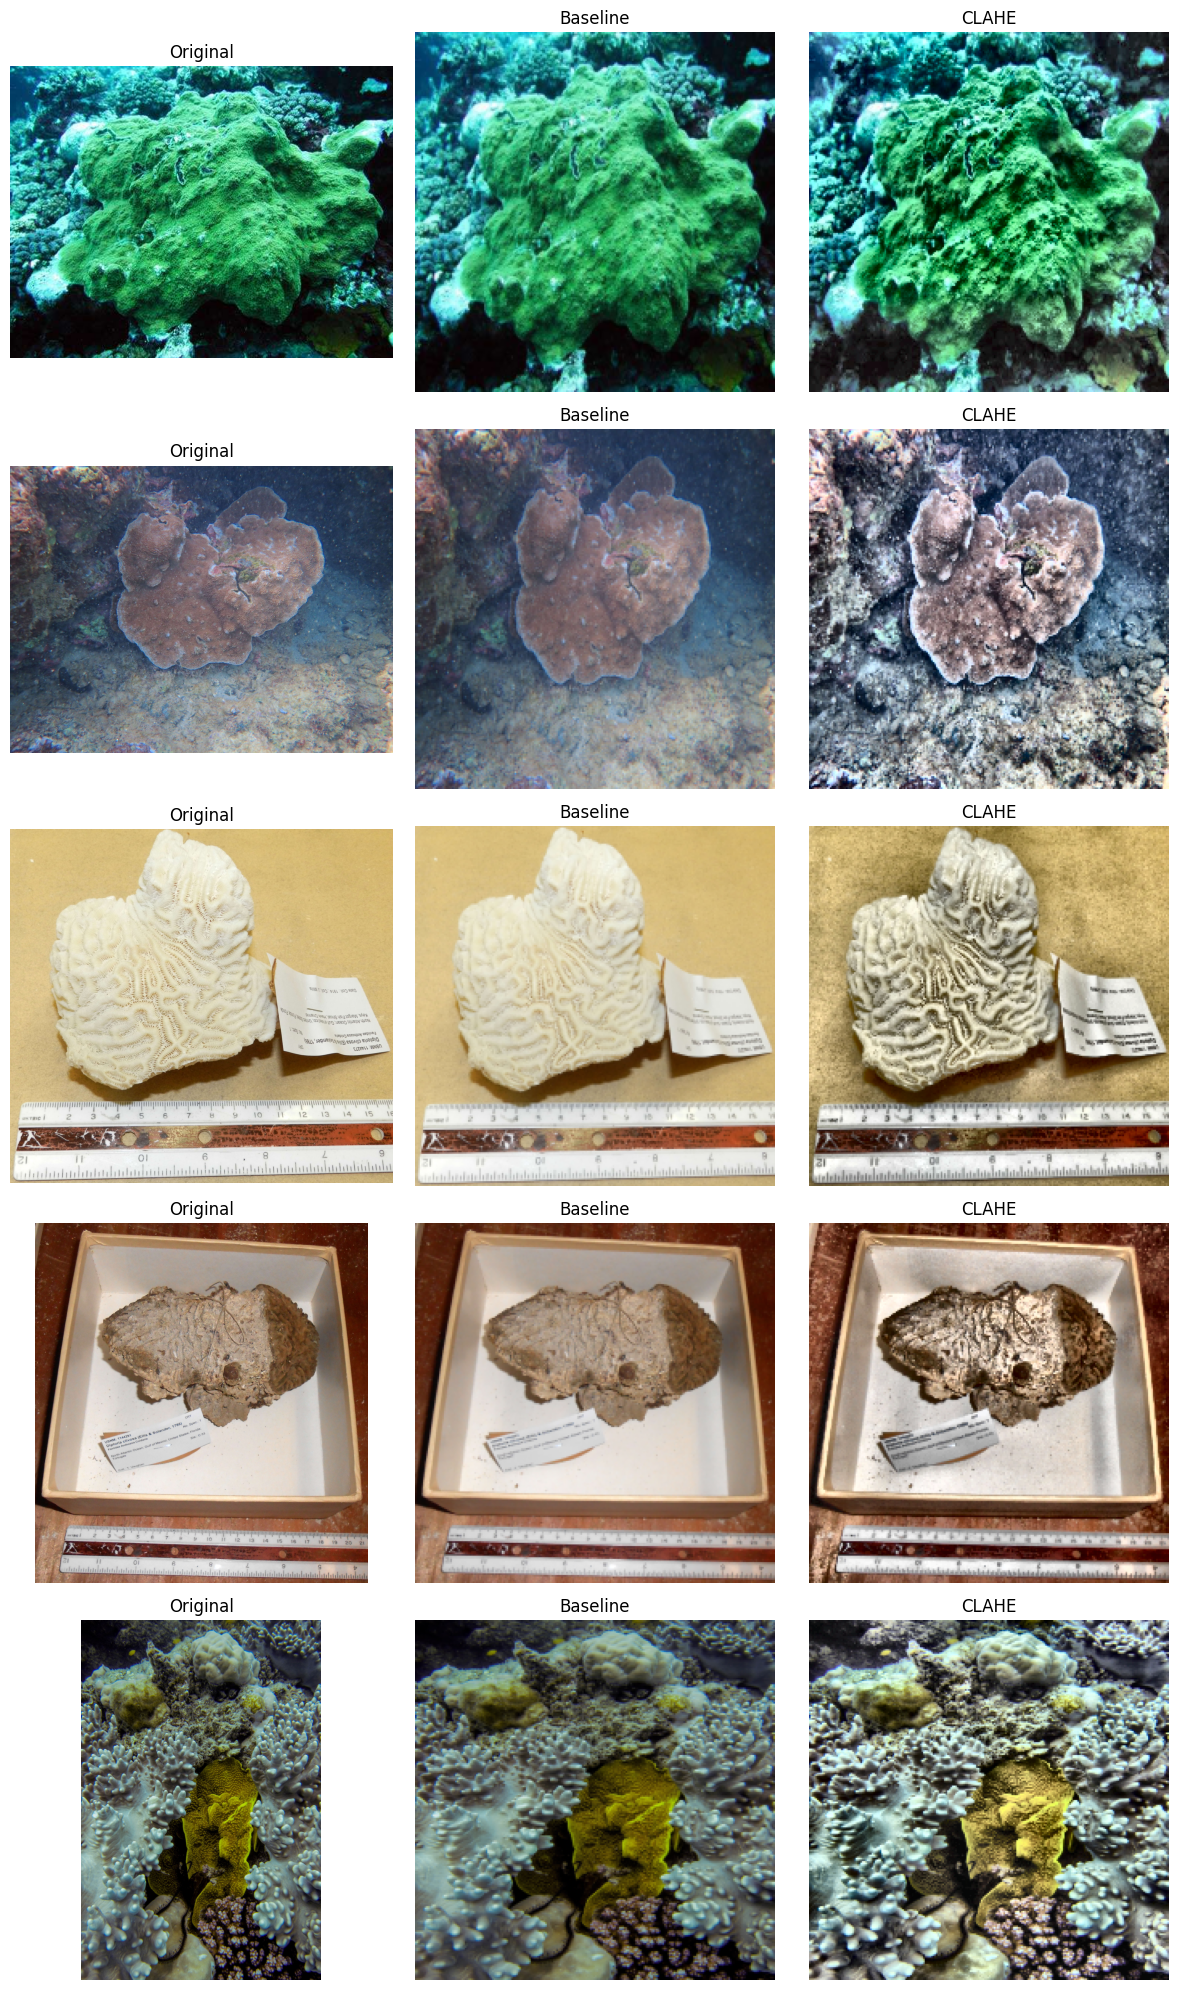

In [ ]:
# import os
# import numpy as np
# import matplotlib.pyplot as plt
# from PIL import Image

# def show_random_image_triplets(
#     df,
#     image_folder="rare_species",
#     baseline_column="resized_image",
#     clahe_column="clahe_image",   # match your actual column name
#     num_samples=10
# ):
#     """
#     Displays random triplets of original, baseline preprocessed, and CLAHE-enhanced images.
#     """
#     sample_df = df.sample(n=num_samples).reset_index(drop=True)

#     # Set up the plot (num_samples rows × 3 columns)
#     fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4 * num_samples), squeeze=False)

#     for i in range(num_samples):
#         row = sample_df.loc[i]
#         file_path = os.path.join(image_folder, row["file_path"])

#         try:
#             # 1) Load original image from disk
#             original = Image.open(file_path).convert("RGB")

#             # 2) Grab the preprocessed arrays
#             baseline = row[baseline_column]
#             clahe    = row[clahe_column]

#             # If they’re stored as nested lists, convert to uint8 arrays
#             if not isinstance(baseline, np.ndarray):
#                 baseline = np.array(baseline, dtype=np.uint8)
#             if not isinstance(clahe, np.ndarray):
#                 clahe = np.array(clahe, dtype=np.uint8)

#             # Display each
#             axes[i, 0].imshow(original)
#             axes[i, 0].set_title("Original")
#             axes[i, 0].axis("off")

#             axes[i, 1].imshow(baseline)
#             axes[i, 1].set_title("Baseline")
#             axes[i, 1].axis("off")

#             axes[i, 2].imshow(clahe)
#             axes[i, 2].set_title("CLAHE")
#             axes[i, 2].axis("off")

#         except Exception as e:
#             # If anything goes wrong, blank out the row
#             print(f"❌ Error on {file_path}: {e}")
#             for j in range(3):
#                 axes[i, j].axis("off")

#     plt.tight_layout()
#     plt.show()


# # Example usage (show 5 random samples):
# show_random_image_triplets(cnidaria_train, num_samples=5)


### Background Removal (GrabCut)

In [86]:
# import cv2
# import numpy as np
# import pandas as pd
# import os
# import matplotlib.pyplot as plt
# from tqdm import tqdm

# # Enable progress_apply for pandas
# tqdm.pandas()

# def grabcut_segmentation(image, iter_count=10):
#     """
#     Uses GrabCut to segment the foreground (coral) from the background,
#     while preserving the original colors.
    
#     Parameters:
#       image (np.array): Input image in RGB.
#       iter_count (int): Number of iterations for GrabCut.
      
#     Returns:
#       segmented_rgb (np.array): The segmented image (foreground in original colors, background zeroed out) in RGB.
#       mask2 (np.array): Binary mask where foreground pixels are 1.
#     """
#     # If the image is in float format ([0,1]), scale to [0,255]
#     if image.dtype != np.uint8:
#         image = (image * 255).astype(np.uint8)
        
#     # Convert from RGB to BGR for OpenCV
#     image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
#     height, width = image_bgr.shape[:2]
#     rect = (int(width * 0.05), int(height * 0.05), int(width * 0.9), int(height * 0.9))
    
#     mask = np.zeros(image_bgr.shape[:2], np.uint8)
#     bgdModel = np.zeros((1, 65), np.float64)
#     fgdModel = np.zeros((1, 65), np.float64)
    
#     cv2.grabCut(image_bgr, mask, rect, bgdModel, fgdModel, iter_count, cv2.GC_INIT_WITH_RECT)
    
#     # Create binary mask: foreground pixels = 1, background = 0
#     mask2 = np.where((mask == cv2.GC_BGD) | (mask == cv2.GC_PR_BGD), 0, 1).astype('uint8')
    
#     # Apply mask to the BGR image (this zeros the background)
#     segmented_bgr = image_bgr * mask2[:, :, np.newaxis]
    
#     # Convert back to RGB
#     segmented_rgb = cv2.cvtColor(segmented_bgr, cv2.COLOR_BGR2RGB)
    
#     return segmented_rgb, mask2

# def crop_to_foreground(image, mask):
#     """
#     Crops the image tightly around the non-zero regions in the mask.
    
#     Parameters:
#       image (np.array): The input segmented image.
#       mask (np.array): Binary mask where foreground pixels are 1.
      
#     Returns:
#       cropped (np.array): Cropped image containing only the foreground.
#     """
#     coords = cv2.findNonZero(mask)
#     if coords is None:
#         return image  # Return original if no foreground detected
#     x, y, w, h = cv2.boundingRect(coords)
#     cropped = image[y:y+h, x:x+w]
#     return cropped

# def process_image(image):
#     """
#     Processes a single image by applying GrabCut segmentation and cropping.
    
#     Parameters:
#       image (np.array): The input resized image (RGB).
      
#     Returns:
#       cropped (np.array): The final cropped image (RGB) with background removed.
#     """
#     if image.dtype != np.uint8:
#         image = image.astype(np.uint8)
#     segmented, mask = grabcut_segmentation(image)
#     cropped = crop_to_foreground(segmented, mask)
#     return cropped

# def add_no_background_images(df):
#     """
#     Processes each image in the DataFrame's 'resized_image' column using
#     GrabCut segmentation and cropping, storing the result in a new column
#     'noBackground_image'.
    
#     Parameters:
#       df (pd.DataFrame): DataFrame containing the 'resized_image' column.
    
#     Returns:
#       df (pd.DataFrame): A new DataFrame that includes a 'noBackground_image'
#                          column holding NumPy arrays.
#     """
#     df = df.copy()
#     column_name = "noBackground_image"
#     df[column_name] = None  # Initialize the new column
#     for idx, row in df.iterrows():
#         try:
#             image = row["resized_image"]
#             processed_img = process_image(image)
#             df.at[idx, column_name] = processed_img
#         except Exception as e:
#             print(f"Couldn't process image at index {idx}: {e}")
#     return df

# # Helper functions to convert string representations to arrays, if needed:
# def string_to_array(s, expected_shape=(224, 224, 3)):
#     s_clean = s.replace('[', '').replace(']', '').replace('\n', ' ').strip()
#     try:
#         numbers = [int(x) for x in s_clean.split() if x]
#         arr = np.array(numbers, dtype=np.uint8)
#         return arr.reshape(expected_shape)
#     except Exception as e:
#         print("Conversion error:", e)
#         raise

# def ensure_array(x):
#     if isinstance(x, np.ndarray):
#         return x
#     elif isinstance(x, str):
#         try:
#             return string_to_array(x)
#         except Exception as e:
#             print("Could not convert string to array:", e)
#             return x
#     else:
#         return x

# # Process the DataFrames to create the noBackground_image column.
# cnidaria_train = add_no_background_images(cnidaria_train)
# cnidaria_test  = add_no_background_images(cnidaria_test)

# # In case some values were stored as strings, attempt to convert them.
# cnidaria_train["noBackground_image"] = cnidaria_train["noBackground_image"].apply(ensure_array)
# cnidaria_test["noBackground_image"]  = cnidaria_test["noBackground_image"].apply(ensure_array)

# # Verify that all entries in the noBackground_image column are now NumPy arrays.
# print("All train images are arrays:", cnidaria_train["noBackground_image"].apply(lambda x: isinstance(x, np.ndarray)).all())
# print("All test images are arrays:", cnidaria_test["noBackground_image"].apply(lambda x: isinstance(x, np.ndarray)).all())


In [87]:
# cnidaria_train.head(3)

In [88]:
# # Get the unique families from the DataFrame
# families = cnidaria_train['family'].unique()

# # Loop over each family
# for family in families:
#     # Filter the DataFrame for the current family
#     family_df = cnidaria_train[cnidaria_train['family'] == family]
    
#     # Select up to 24 images; if more than 24 are available, randomly sample 24
#     if len(family_df) > 24:
#         sample_df = family_df.sample(n=24, random_state=42)
#     else:
#         sample_df = family_df
    
#     # Extract the processed images from the "noBackground_image" column
#     sample_images = sample_df['noBackground_image'].tolist()
    
#     n = len(sample_images)
#     cols = 6
#     rows = int(np.ceil(n / cols))
    
#     # Create a grid of subplots
#     fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
#     fig.suptitle(f"Family: {family}", fontsize=16)
    
#     # Flatten axes for easier iteration
#     axes = np.array(axes).flatten() if n > 1 else [axes]
    
#     for idx, (ax, img) in enumerate(zip(axes, sample_images)):
#         # Convert from BGR to RGB for correct color display with matplotlib
#         try:
#             img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         except Exception as e:
#             # If conversion fails, assume the image is already RGB
#             img_rgb = img
#         ax.imshow(img_rgb)
#         ax.axis("off")
    
#     # Hide any remaining empty subplots
#     for ax in axes[n:]:
#         ax.set_visible(False)
    
#     plt.tight_layout(rect=[0, 0, 1, 0.95])
#     plt.show()

Background removal works for some, other images get completly removed. Therefore, do a combination of background removal images and use the rescaled image for the ones where background removal did not work.

In [89]:
# def is_uniform(image, threshold=10):
#     """
#     Determines if the image is nearly uniform in color.
    
#     Parameters:
#       image (np.array): The image to check.
#       threshold (float): If the standard deviation of the image is below this value, 
#                          the image is considered nearly uniform.
                         
#     Returns:
#       bool: True if the image is nearly uniform, False otherwise.
#     """
#     # Compute the overall standard deviation of pixel values
#     std_val = np.std(image)
#     return std_val < threshold

# def replace_uniform_image(row, threshold=10):
#     """
#     Replaces the 'noBackground_image' with the 'resized_image' if it is completely black 
#     or nearly uniform (i.e., a singular block color).
    
#     Parameters:
#       row (pd.Series): A row from the DataFrame.
#       threshold (float): The standard deviation threshold to consider an image uniform.
      
#     Returns:
#       np.array: The original resized image if the noBackground_image is uniform; 
#                 otherwise, the noBackground_image.
#     """
#     no_bg_img = row['noBackground_image']
    
#     # If image is missing or completely black, replace it.
#     if no_bg_img is None or np.count_nonzero(no_bg_img) == 0:
#         return row['resized_image']
    
#     # If the image has very low variance (i.e., nearly uniform), replace it.
#     if is_uniform(no_bg_img, threshold):
#         return row['resized_image']
    
#     # Otherwise, return the noBackground_image as is.
#     return no_bg_img

# # Apply the function row-wise on the DataFrame 'cnidaria_train'
# cnidaria_train['mixed_image'] = cnidaria_train.apply(lambda row: replace_uniform_image(row, threshold=10), axis=1)
# cnidaria_test['mixed_image'] = cnidaria_test.apply(lambda row: replace_uniform_image(row, threshold=10), axis=1)


In [90]:
# # Get the unique families from the DataFrame
# families = cnidaria_train['family'].unique()

# # Loop over each family
# for family in families:
#     # Filter the DataFrame for the current family
#     family_df = cnidaria_train[cnidaria_train['family'] == family]
    
#     # Select up to 24 images; if more than 24 are available, randomly sample 24
#     if len(family_df) > 24:
#         sample_df = family_df.sample(n=24, random_state=42)
#     else:
#         sample_df = family_df
    
#     # Extract the processed images from the "noBackground_image" column
#     sample_images = sample_df['noBackground _image'].tolist()
    
#     n = len(sample_images)
#     cols = 6
#     rows = int(np.ceil(n / cols))
    
#     # Create a grid of subplots
#     fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
#     fig.suptitle(f"Family: {family}", fontsize=16)
    
#     # Flatten axes for easier iteration
#     axes = np.array(axes).flatten() if n > 1 else [axes]
    
#     for idx, (ax, img) in enumerate(zip(axes, sample_images)):
#         # Convert from BGR to RGB for correct color display with matplotlib
#         try:
#             img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         except Exception as e:
#             # If conversion fails, assume the image is already RGB
#             img_rgb = img
#         ax.imshow(img_rgb)
#         ax.axis("off")
    
#     # Hide any remaining empty subplots
#     for ax in axes[n:]:
#         ax.set_visible(False)
    
#     plt.tight_layout(rect=[0, 0, 1, 0.95])
#     plt.show()

In [91]:
# # Save the processed DataFrame to a CSV file
# cnidaria_train.to_csv("train_test_splits/cnidaria_train_processed.csv", index=False)
# cnidaria_test.to_csv("train_test_splits/cnidaria_test_processed.csv", index=False)

### Background Removal (U-2-Net)

In [ ]:
# # If you haven’t already installed rembg:
# # pip install rembg

# import numpy as np
# import pandas as pd
# from PIL import Image
# from rembg import remove  # rembg uses U‑2‑Net under the hood

# # --- 1) Define your background‑removal functions ----

# def remove_bg_rgba(img_np: np.ndarray) -> np.ndarray:
#     """
#     Remove background via U-2-Net (transparent background).
#     Input: H×W×3 uint8 RGB array
#     Output: H×W×4 uint8 RGBA array (alpha=0 → background)
#     """
#     pil = Image.fromarray(img_np)          # numpy → PIL
#     out_pil = remove(pil)                  # run U‑2‑Net
#     return np.asarray(out_pil)             # back to numpy

# def remove_bg_black(img_np: np.ndarray) -> np.ndarray:
#     """
#     Remove background and composite on black.
#     Input: H×W×3 uint8 RGB array
#     Output: H×W×3 uint8 RGB array (background black)
#     """
#     rgba = remove_bg_rgba(img_np)
#     rgb  = rgba[..., :3].astype(np.float32)
#     alpha = (rgba[..., 3:4] / 255.0).astype(np.float32)
#     # foreground * alpha + black * (1−alpha)
#     blended = (rgb * alpha).astype(np.uint8)
#     return blended


In [ ]:
# # --- 2) Apply over your DataFrame ----

# # Choose your preferred function:
# # bg_fn = remove_bg_rgba      # for transparent PNGs
# bg_fn = remove_bg_black   # for blacked‑out background

# cnidaria_train['noBackground_image'] = cnidaria_train['resized_image'].apply(bg_fn)
# cnidaria_test['noBackground_image'] = cnidaria_test['resized_image'].apply(bg_fn)

# # Save the processed DataFrame to a CSV file
# cnidaria_train.to_csv("train_test_splits/cnidaria_train_processed.csv", index=False)
# cnidaria_test.to_csv("train_test_splits/cnidaria_test_processed.csv", index=False)

# # --- 3) Inspect the updated DataFrame ----
# display(cnidaria_train.head())

eol_content_id  eol_page_id   kingdom    phylum            family  \
0        28219388     45276311  animalia  cnidaria       acroporidae   
1        29729570     45276321  animalia  cnidaria       acroporidae   
2        20332243     46545536  animalia  cnidaria    lobophylliidae   
3        22357017     45275716  animalia  cnidaria  dendrophylliidae   
4        28343272     45276323  animalia  cnidaria       acroporidae   

                                           file_path  \
0  cnidaria_acroporidae/28219388_45276311_eol-ful...   
1  cnidaria_acroporidae/29729570_45276321_eol-ful...   
2  cnidaria_lobophylliidae/20332243_46545536_eol-...   
3  cnidaria_dendrophylliidae/22357017_45275716_eo...   
4  cnidaria_acroporidae/28343272_45276323_eol-ful...   

                                       resized_image  \
0  [[[76, 74, 71], [73, 70, 71], [74, 71, 72], [7...   
1  [[[202, 202, 170], [195, 186, 156], [209, 197,...   
2  [[[8, 159, 90], [9, 183, 111], [2, 212, 128], ...   
3  [[[46, 87, 221], [35, 85, 251], [128, 132, 231...   
4  [[[24, 24, 22], [25, 25, 24], [26, 26, 26], [2...   

                                         clahe_image  \
0  [[[72, 70, 67], [57, 53, 54], [58, 56, 57], [8...   
1  [[[157, 157, 126], [135, 128, 100], [158, 149,...   
2  [[[0, 78, 19], [0, 113, 49], [0, 185, 103], [0...   
3  [[[35, 82, 214], [46, 90, 255], [127, 131, 230...   
4  [[[10, 14, 8], [17, 16, 14], [20, 20, 20], [20...   

                                  noBackground_image  
0  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  
1  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  
2  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  
3  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  
4  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...

#### Black Detection

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from tqdm import tqdm

# # 1) The same pixel‐based “mostly black” test:
# def has_predominantly_black_background(image_array: np.ndarray,
#                                        black_max_threshold: int = 30,
#                                        percentage_threshold: float = 0.9) -> bool:
#     """
#     Returns True if more than `percentage_threshold` of pixels in `image_array`
#     have all channels ≤ black_max_threshold.
#     """
#     # count pixels where R,G,B ≤ threshold
#     black_pixels = np.sum(
#         (image_array[..., 0] <= black_max_threshold) &
#         (image_array[..., 1] <= black_max_threshold) &
#         (image_array[..., 2] <= black_max_threshold)
#     )
#     total_pixels = image_array.shape[0] * image_array.shape[1]
#     return (black_pixels / total_pixels) > percentage_threshold


# # 2) Iterate over your df, check the chosen image‑column, write a boolean flag:
# def add_black_background_check(df: pd.DataFrame,
#                                image_column: str = "noBackground_imageU2",
#                                output_column: str = "has_black_background",
#                                black_max_threshold: int = 30,
#                                percentage_threshold: float = 0.9):
#     """
#     Returns a copy of df with a new boolean column `output_column` showing
#     which rows have a predominantly black background in `image_column`.
#     Also returns a list of indices where it was True.
#     """
#     df = df.copy()
#     df[output_column] = False
#     black_idxs = []
    
#     for idx, img_arr in tqdm(df[image_column].items(),
#                              total=len(df),
#                              desc="Checking for black backgrounds"):
#         # skip missing or malformed
#         if not isinstance(img_arr, np.ndarray) or img_arr.ndim < 3:
#             continue
        
#         try:
#             is_black = has_predominantly_black_background(
#                 img_arr, black_max_threshold, percentage_threshold
#             )
#         except Exception:
#             is_black = False
        
#         df.at[idx, output_column] = is_black
#         if is_black:
#             black_idxs.append(idx)
    
#     return df, black_idxs


# # 3) A quick viewer that pulls arrays out of the df instead of from files:
# def display_black_background_images_from_df(df: pd.DataFrame,
#                                             black_idxs: list,
#                                             image_column: str = "noBackground_imageU2",
#                                             max_images: int = 8):
#     """
#     Displays up to `max_images` examples from df.loc[black_idxs, image_column].
#     """
#     n = min(len(black_idxs), max_images)
#     if n == 0:
#         print("No predominantly‑black images found.")
#         return
    
#     fig, axes = plt.subplots(1, n, figsize=(4 * n, 4))
#     axes = axes if n > 1 else [axes]
    
#     for ax, idx in zip(axes, black_idxs[:n]):
#         img = df.at[idx, image_column]
#         ax.imshow(img)
#         ax.set_title(f"idx={idx}")
#         ax.axis("off")
    
#     plt.tight_layout()
#     plt.show()
 

Checking for black backgrounds: 100%|██████████| 162/162 [00:00<00:00, 6664.94it/s]


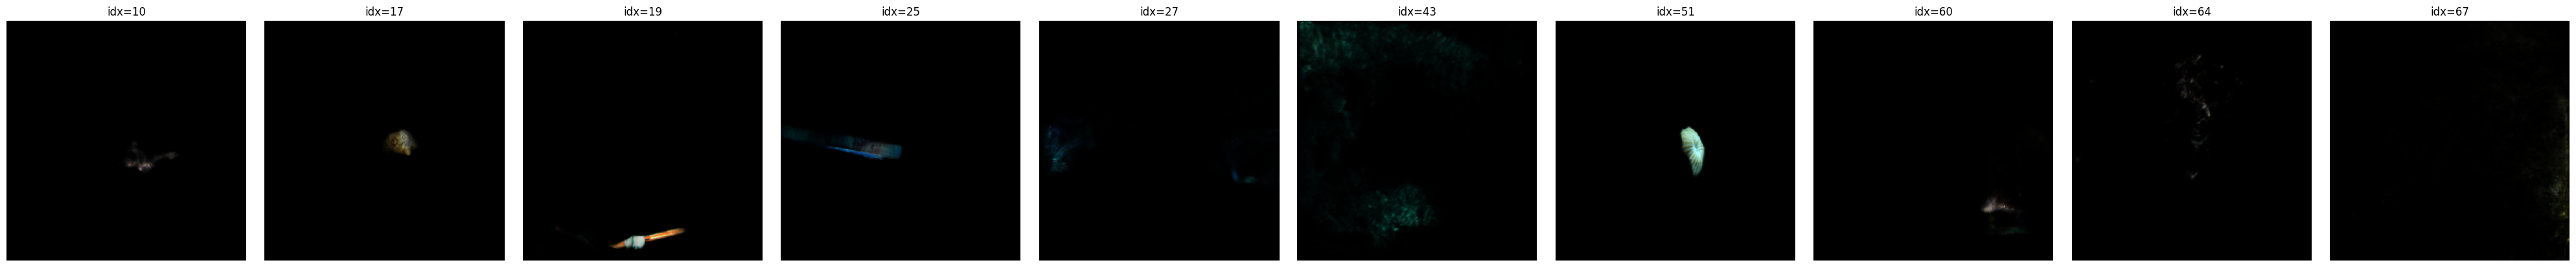

eol_content_id  eol_page_id   kingdom    phylum            family  \
0        28219388     45276311  animalia  cnidaria       acroporidae   
1        29729570     45276321  animalia  cnidaria       acroporidae   
2        20332243     46545536  animalia  cnidaria    lobophylliidae   
3        22357017     45275716  animalia  cnidaria  dendrophylliidae   
4        28343272     45276323  animalia  cnidaria       acroporidae   

                                           file_path  \
0  cnidaria_acroporidae/28219388_45276311_eol-ful...   
1  cnidaria_acroporidae/29729570_45276321_eol-ful...   
2  cnidaria_lobophylliidae/20332243_46545536_eol-...   
3  cnidaria_dendrophylliidae/22357017_45275716_eo...   
4  cnidaria_acroporidae/28343272_45276323_eol-ful...   

                                       resized_image  \
0  [[[76, 74, 71], [73, 70, 71], [74, 71, 72], [7...   
1  [[[202, 202, 170], [195, 186, 156], [209, 197,...   
2  [[[8, 159, 90], [9, 183, 111], [2, 212, 128], ...   
3  [[[46, 87, 221], [35, 85, 251], [128, 132, 231...   
4  [[[24, 24, 22], [25, 25, 24], [26, 26, 26], [2...   

                                         clahe_image  \
0  [[[72, 70, 67], [57, 53, 54], [58, 56, 57], [8...   
1  [[[157, 157, 126], [135, 128, 100], [158, 149,...   
2  [[[0, 78, 19], [0, 113, 49], [0, 185, 103], [0...   
3  [[[35, 82, 214], [46, 90, 255], [127, 131, 230...   
4  [[[10, 14, 8], [17, 16, 14], [20, 20, 20], [20...   

                                  noBackground_image  has_black_background  
0  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...                 False  
1  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...                 False  
2  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...                 False  
3  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...                 False  
4  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...                 False

In [ ]:
# # (1) run the check on your chosen BG‑removed column:
# cnidaria_train, black_idxs_train = add_black_background_check(
#     cnidaria_train,
#     image_column="noBackground_image",
#     output_column="has_black_background",
#     black_max_threshold=30,
#     percentage_threshold=0.98
# )

# cnidaria_test, black_idxs_test = add_black_background_check(
#     cnidaria_test,
#     image_column="noBackground_image",
#     output_column="has_black_background",
#     black_max_threshold=30,
#     percentage_threshold=0.98
# )

# # (2) peek at the first few flagged cases:
# display_black_background_images_from_df(
#     cnidaria_train,
#     black_idxs_train,
#     image_column="noBackground_image",
#     max_images=10
# )

# # (3) And your df now has a True/False column:
# cnidaria_train.head() 

In [ ]:
# cnidaria_train['has_black_background'].value_counts()

has_black_background
False    519
True     128
Name: count, dtype: int64

#### Mixed Image Column

In [ ]:
# # --- 1) Define a selector function ---
# def select_mixed_image(row,
#                        bg_flag_col: str = "has_black_background",
#                        bg_removed_col: str = "noBackground_image",
#                        fallback_col: str = "clahe_image") -> np.ndarray:
#     """
#     Returns `image_clahe` if row[bg_flag_col] is True (i.e. bad bg removal),
#     otherwise returns the background‑removed image from bg_removed_col.
#     """
#     if row[bg_flag_col]:
#         return row[fallback_col]
#     else:
#         return row[bg_removed_col]

# # --- 2) Apply to your DataFrame ---
# cnidaria_train["mixed_image"] = cnidaria_train.apply(select_mixed_image, axis=1)
# cnidaria_test["mixed_image"] = cnidaria_test.apply(select_mixed_image, axis=1)

# # --- 3) Peek at the result ---
# display(cnidaria_train[[
#     "file_path",
#     "has_black_background",
#     "clahe_image",
#     "noBackground_image",
#     "mixed_image"
# ]].head())


file_path  has_black_background  \
0  cnidaria_acroporidae/28219388_45276311_eol-ful...                 False   
1  cnidaria_acroporidae/29729570_45276321_eol-ful...                 False   
2  cnidaria_lobophylliidae/20332243_46545536_eol-...                 False   
3  cnidaria_dendrophylliidae/22357017_45275716_eo...                 False   
4  cnidaria_acroporidae/28343272_45276323_eol-ful...                 False   

                                         clahe_image  \
0  [[[72, 70, 67], [57, 53, 54], [58, 56, 57], [8...   
1  [[[157, 157, 126], [135, 128, 100], [158, 149,...   
2  [[[0, 78, 19], [0, 113, 49], [0, 185, 103], [0...   
3  [[[35, 82, 214], [46, 90, 255], [127, 131, 230...   
4  [[[10, 14, 8], [17, 16, 14], [20, 20, 20], [20...   

                                  noBackground_image  \
0  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
1  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
2  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
3  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
4  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   

                                         mixed_image  
0  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  
1  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  
2  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  
3  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  
4  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...

In [ ]:
# #save the processed DataFrame to a CSV file
# cnidaria_train.to_pickle("train_test_splits/cnidaria_train_processed.pkl")
# cnidaria_test.to_pickle("train_test_splits/cnidaria_test_processed.pkl")

# 5. Neural Network Models <a class="anchor" id="nnmodels"></a>

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
import numpy as np
import os
from tensorflow.keras.callbacks import ModelCheckpoint

# Standard libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import zipfile
import seaborn as sns

# Libraries for image processing
from glob import glob
from PIL import Image

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras import layers, models, optimizers

from tqdm.auto import tqdm

/root/DeepLearning2425/tf-gpu/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
cnidaria_train = pd.read_pickle("train_test_splits/cnidaria_train_processed.pkl")
cnidaria_test = pd.read_pickle("train_test_splits/cnidaria_test_processed.pkl")

## 5.1 Baseline Model 

### Model Setup

In [5]:
input_shape = cnidaria_train['resized_image'].iloc[0].shape

X_train = np.stack(cnidaria_train['resized_image'].values)
X_test = np.stack(cnidaria_test['resized_image'].values)

# Normalize image data to the range [0, 1]
X_train = X_train / 255.0
X_test = X_test / 255.0

le = LabelEncoder()
y_train_encoded = le.fit_transform(cnidaria_train['family'])
y_test_encoded = le.transform(cnidaria_test['family'])

y_train_cat = to_categorical(y_train_encoded)
y_test_cat = to_categorical(y_test_encoded)

num_classes = y_train_cat.shape[1]

# Compute class weights
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_encoded),
    y=y_train_encoded
)
class_weights_dict = dict(enumerate(class_weights))

print("Class weights:", class_weights_dict)

Class weights: {0: np.float64(0.29624542124542125), 1: np.float64(0.5238866396761134), 2: np.float64(2.073717948717949), 3: np.float64(2.073717948717949), 4: np.float64(0.6912393162393162), 5: np.float64(1.0368589743589745), 6: np.float64(2.073717948717949), 7: np.float64(2.073717948717949), 8: np.float64(2.073717948717949), 9: np.float64(2.073717948717949), 10: np.float64(1.0368589743589745), 11: np.float64(1.0368589743589745), 12: np.float64(2.073717948717949)}


In [6]:
# Set up callbacks
from tensorflow.keras.callbacks import Callback  # Import Callback

# Build the model
input_layer = Input(shape=input_shape)

conv1 = Conv2D(20, kernel_size=(3, 3), padding="same", activation="relu", kernel_regularizer=l2(0.001))(input_layer)
pool1 = MaxPooling2D(pool_size=(3, 3))(conv1)

conv2 = Conv2D(40, kernel_size=(3, 3), padding="same", activation="relu", kernel_regularizer=l2(0.001))(pool1)
pool2 = MaxPooling2D(pool_size=(3, 3))(conv2)

conv3 = Conv2D(60, kernel_size=(3, 3), padding="same", activation="relu", kernel_regularizer=l2(0.001))(pool2)

flatten = Flatten()(conv3)

dense1 = Dense(512, activation="relu", kernel_regularizer=l2(0.001))(flatten)
drop1 = Dropout(0.5)(dense1)

dense2 = Dense(256, activation="relu", kernel_regularizer=l2(0.001))(drop1)
drop2 = Dropout(0.5)(dense2)

output_layer = Dense(num_classes, activation="softmax")(drop2)

baseline_model = Model(inputs=input_layer, outputs=output_layer)
baseline_model.summary()

# Compile
baseline_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



os.makedirs("models/cnidaria_models", exist_ok=True)

class EpochPrinter(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        # epochs are zero‑indexed internally, so +1 for human‑friendly output
        print(f"Epoch {epoch+1}/{self.params['epochs']}")

checkpoint = ModelCheckpoint(
    "models/cnidaria_models/baseline_model.keras",
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

I0000 00:00:1745331668.542358    5859 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5329 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:07:00.0, compute capability: 8.6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 20)   │           560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 74, 74, 40)     │         7,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 40)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 60)     │        21,660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 34560)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    17,695,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 13)             │         3,341 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,859,361 (68.13 MB)

 Trainable params: 17,859,361 (68.13 MB)

 Non-trainable params: 0 (0.00 B)

### Model Training

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image augmentation
train_datagen = ImageDataGenerator(
    rotation_range=40,        # Random rotation
    width_shift_range=0.2,    # Random width shift
    height_shift_range=0.2,   # Random height shift
    shear_range=0.2,          # Random shear
    zoom_range=0.2,           # Random zoom
    horizontal_flip=True,     # Random horizontal flip
    fill_mode='nearest'       # Fill mode for empty pixels after transformation
)

In [8]:

# Create a data generator for training data
train_generator = train_datagen.flow(X_train, y_train_cat, batch_size=8)

# Train the model with augmented data
history_baseline = baseline_model.fit(
    train_generator,
    epochs=40,
    validation_data=(X_test, y_test_cat),
    class_weight=class_weights_dict,
    callbacks=[checkpoint, early_stop],
    verbose=1
)

Epoch 1/40


/root/DeepLearning2425/tf-gpu/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745331672.594990    6186 service.cc:152] XLA service 0x7fcae000d2b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745331672.595026    6186 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2025-04-22 15:21:12.665939: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745331672.978182    6186 cuda_dnn.cc:529] Loaded cuDNN version 90800


 1/81 ━━━━━━━━━━━━━━━━━━━━ 21:25 16s/step - accuracy: 0.1250 - loss: 3.9617

I0000 00:00:1745331687.006235    6186 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.0647 - loss: 3.7919

2025-04-22 15:21:41.640643: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_154_0', 44 bytes spill stores, 44 bytes spill loads

2025-04-22 15:21:42.158706: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_154', 484 bytes spill stores, 484 bytes spill loads

2025-04-22 15:21:45.407452: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_154', 64 bytes spill stores, 64 bytes spill loads




Epoch 1: val_loss improved from inf to 3.02440, saving model to models/cnidaria_models/baseline_model.keras
81/81 ━━━━━━━━━━━━━━━━━━━━ 38s 278ms/step - accuracy: 0.0647 - loss: 3.7868 - val_accuracy: 0.0741 - val_loss: 3.0244
Epoch 2/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.0673 - loss: 2.9857
Epoch 2: val_loss improved from 3.02440 to 2.84815, saving model to models/cnidaria_models/baseline_model.keras
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.0671 - loss: 2.9849 - val_accuracy: 0.0370 - val_loss: 2.8482
Epoch 3/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.0751 - loss: 2.9176
Epoch 3: val_loss improved from 2.84815 to 2.77951, saving model to models/cnidaria_models/baseline_model.keras
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - accuracy: 0.0749 - loss: 2.9164 - val_accuracy: 0.0370 - val_loss: 2.7795
Epoch 4/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.0840 - loss: 2.7514
Epoch 4: val_loss improved from 2.77951 to 2.74121, saving mod

: 

### Result Visualizations

In [10]:
#This function is used in notebook 2, notebook 3 and notebook 4
import matplotlib.pyplot as plt

def plot_loss(history):
    """
    Plot the training and validation loss over epochs.

    Parameters:
    - history: History object returned by model.fit() containing training/validation loss values.

    Returns:
    - None (displays a plot of training and validation loss)
    """
    plt.figure(figsize=(7, 2))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()


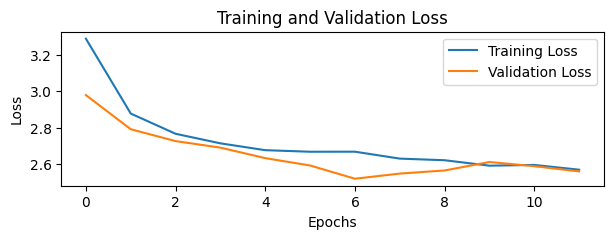

In [12]:
plot_loss(history_baseline)

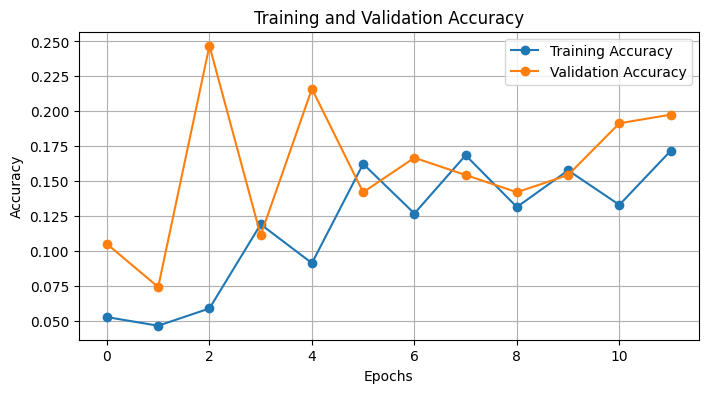

In [13]:
def plot_accuracy(history):
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.grid(True)
    plt.show()

plot_accuracy(history_baseline)


## 5.2 Advanced Pre-Processing Model (Clahe)

### Model Setup

In [22]:
input_shape = cnidaria_train['clahe_image'].iloc[0].shape

X_train = np.stack(cnidaria_train['clahe_image'].values)
X_test = np.stack(cnidaria_test['clahe_image'].values)

# Normalize image data to the range [0, 1]
X_train = X_train / 255.0
X_test = X_test / 255.0

le = LabelEncoder()
y_train_encoded = le.fit_transform(cnidaria_train['family'])
y_test_encoded = le.transform(cnidaria_test['family'])

y_train_cat = to_categorical(y_train_encoded)
y_test_cat = to_categorical(y_test_encoded)

num_classes = y_train_cat.shape[1]

# Compute class weights
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_encoded),
    y=y_train_encoded
)
class_weights_dict = dict(enumerate(class_weights))

print("Class weights:", class_weights_dict)

Class weights: {0: np.float64(0.29624542124542125), 1: np.float64(0.5238866396761134), 2: np.float64(2.073717948717949), 3: np.float64(2.073717948717949), 4: np.float64(0.6912393162393162), 5: np.float64(1.0368589743589745), 6: np.float64(2.073717948717949), 7: np.float64(2.073717948717949), 8: np.float64(2.073717948717949), 9: np.float64(2.073717948717949), 10: np.float64(1.0368589743589745), 11: np.float64(1.0368589743589745), 12: np.float64(2.073717948717949)}


In [23]:
# Set up callbacks
from tensorflow.keras.callbacks import Callback  # Import Callback

# Build the model
input_layer = Input(shape=input_shape)

conv1 = Conv2D(20, kernel_size=(3, 3), padding="same", activation="relu", kernel_regularizer=l2(0.001))(input_layer)
pool1 = MaxPooling2D(pool_size=(3, 3))(conv1)

conv2 = Conv2D(40, kernel_size=(3, 3), padding="same", activation="relu", kernel_regularizer=l2(0.001))(pool1)
pool2 = MaxPooling2D(pool_size=(3, 3))(conv2)

conv3 = Conv2D(60, kernel_size=(3, 3), padding="same", activation="relu", kernel_regularizer=l2(0.001))(pool2)

flatten = Flatten()(conv3)

dense1 = Dense(512, activation="relu", kernel_regularizer=l2(0.001))(flatten)
drop1 = Dropout(0.5)(dense1)

dense2 = Dense(256, activation="relu", kernel_regularizer=l2(0.001))(drop1)
drop2 = Dropout(0.5)(dense2)

output_layer = Dense(num_classes, activation="softmax")(drop2)

baseline_model = Model(inputs=input_layer, outputs=output_layer)
baseline_model.summary()

# Compile
baseline_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



os.makedirs("models/cnidaria_models", exist_ok=True)

class EpochPrinter(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        # epochs are zero‑indexed internally, so +1 for human‑friendly output
        print(f"Epoch {epoch+1}/{self.params['epochs']}")

checkpoint = ModelCheckpoint(
    "models/cnidaria_models/baseline_model.keras",
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 20)   │           560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 74, 74, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 74, 74, 40)     │         7,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 24, 24, 40)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 24, 24, 60)     │        21,660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 34560)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │    17,695,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 13)             │         3,341 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,859,361 (68.13 MB)

 Trainable params: 17,859,361 (68.13 MB)

 Non-trainable params: 0 (0.00 B)

### Model Training

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image augmentation
train_datagen = ImageDataGenerator(
    rotation_range=40,        # Random rotation
    width_shift_range=0.2,    # Random width shift
    height_shift_range=0.2,   # Random height shift
    shear_range=0.2,          # Random shear
    zoom_range=0.2,           # Random zoom
    horizontal_flip=True,     # Random horizontal flip
    fill_mode='nearest'       # Fill mode for empty pixels after transformation
)

In [25]:
# Create a data generator for training data
train_generator = train_datagen.flow(X_train, y_train_cat, batch_size=16)

# Train the model with augmented data
history_clahe = baseline_model.fit(
    train_generator,
    epochs=100,
    validation_data=(X_test, y_test_cat),
    class_weight=class_weights_dict,
    callbacks=[checkpoint, early_stop],
    verbose=1
)

/root/DeepLearning2425/tf-gpu/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.0542 - loss: 4.0883
Epoch 1: val_loss improved from inf to 3.24067, saving model to models/cnidaria_models/baseline_model.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 233ms/step - accuracy: 0.0545 - loss: 4.0766 - val_accuracy: 0.0370 - val_loss: 3.2407
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.0559 - loss: 3.2433
Epoch 2: val_loss improved from 3.24067 to 3.03177, saving model to models/cnidaria_models/baseline_model.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.0560 - loss: 3.2406 - val_accuracy: 0.1111 - val_loss: 3.0318
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.0716 - loss: 3.0170
Epoch 3: val_loss improved from 3.03177 to 2.92860, saving model to models/cnidaria_models/baseline_model.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 0.0716 - loss: 3.0162 - val_accuracy: 0.0370 - val_loss: 2.9286
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - 

### Result Visualizations

In [26]:
#This function is used in notebook 2, notebook 3 and notebook 4
import matplotlib.pyplot as plt

def plot_loss(history):
    """
    Plot the training and validation loss over epochs.

    Parameters:
    - history: History object returned by model.fit() containing training/validation loss values.

    Returns:
    - None (displays a plot of training and validation loss)
    """
    plt.figure(figsize=(7, 2))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()


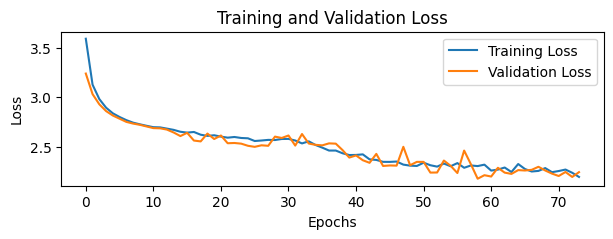

In [27]:
plot_loss(history_clahe)

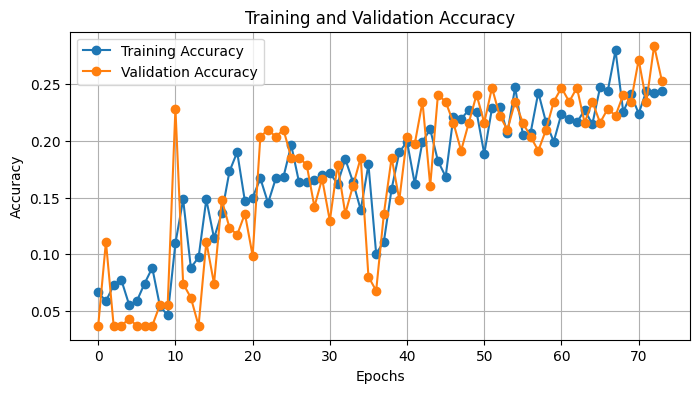

In [28]:
def plot_accuracy(history):
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.grid(True)
    plt.show()

plot_accuracy(history_clahe)


## 5.3 Advanced Pre-Processing Model (Background Removal)

### Model Setup

In [15]:
input_shape = cnidaria_train['mixed_image'].iloc[0].shape

X_train = np.stack(cnidaria_train['mixed_image'].values)
X_test = np.stack(cnidaria_test['mixed_image'].values)

# Normalize image data to the range [0, 1]
X_train = X_train / 255.0
X_test = X_test / 255.0

le = LabelEncoder()
y_train_encoded = le.fit_transform(cnidaria_train['family'])
y_test_encoded = le.transform(cnidaria_test['family'])

y_train_cat = to_categorical(y_train_encoded)
y_test_cat = to_categorical(y_test_encoded)

num_classes = y_train_cat.shape[1]

# Compute class weights
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_encoded),
    y=y_train_encoded
)
class_weights_dict = dict(enumerate(class_weights))

print("Class weights:", class_weights_dict)

Class weights: {0: np.float64(0.29624542124542125), 1: np.float64(0.5238866396761134), 2: np.float64(2.073717948717949), 3: np.float64(2.073717948717949), 4: np.float64(0.6912393162393162), 5: np.float64(1.0368589743589745), 6: np.float64(2.073717948717949), 7: np.float64(2.073717948717949), 8: np.float64(2.073717948717949), 9: np.float64(2.073717948717949), 10: np.float64(1.0368589743589745), 11: np.float64(1.0368589743589745), 12: np.float64(2.073717948717949)}


In [16]:
# Set up callbacks
from tensorflow.keras.callbacks import Callback  # Import Callback

# Build the model
input_layer = Input(shape=input_shape)

conv1 = Conv2D(20, kernel_size=(3, 3), padding="same", activation="relu", kernel_regularizer=l2(0.001))(input_layer)
pool1 = MaxPooling2D(pool_size=(3, 3))(conv1)

conv2 = Conv2D(40, kernel_size=(3, 3), padding="same", activation="relu", kernel_regularizer=l2(0.001))(pool1)
pool2 = MaxPooling2D(pool_size=(3, 3))(conv2)

conv3 = Conv2D(60, kernel_size=(3, 3), padding="same", activation="relu", kernel_regularizer=l2(0.001))(pool2)

flatten = Flatten()(conv3)

dense1 = Dense(512, activation="relu", kernel_regularizer=l2(0.001))(flatten)
drop1 = Dropout(0.5)(dense1)

dense2 = Dense(256, activation="relu", kernel_regularizer=l2(0.001))(drop1)
drop2 = Dropout(0.5)(dense2)

output_layer = Dense(num_classes, activation="softmax")(drop2)

baseline_model = Model(inputs=input_layer, outputs=output_layer)
baseline_model.summary()

# Compile
baseline_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



os.makedirs("models/cnidaria_models", exist_ok=True)

class EpochPrinter(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        # epochs are zero‑indexed internally, so +1 for human‑friendly output
        print(f"Epoch {epoch+1}/{self.params['epochs']}")

checkpoint = ModelCheckpoint(
    "models/cnidaria_models/baseline_model(br).keras",
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 20)   │           560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 74, 74, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 74, 74, 40)     │         7,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 24, 24, 40)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 60)     │        21,660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 34560)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │    17,695,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 13)             │         3,341 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,859,361 (68.13 MB)

 Trainable params: 17,859,361 (68.13 MB)

 Non-trainable params: 0 (0.00 B)

### Model Training

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image augmentation
train_datagen = ImageDataGenerator(
    rotation_range=40,        # Random rotation
    width_shift_range=0.2,    # Random width shift
    height_shift_range=0.2,   # Random height shift
    shear_range=0.2,          # Random shear
    zoom_range=0.2,           # Random zoom
    horizontal_flip=True,     # Random horizontal flip
    fill_mode='nearest'       # Fill mode for empty pixels after transformation
)

In [18]:
# Create a data generator for training data
train_generator = train_datagen.flow(X_train, y_train_cat, batch_size=16)

# Train the model with augmented data
history_br = baseline_model.fit(
    train_generator,
    epochs=40,
    validation_data=(X_test, y_test_cat),
    class_weight=class_weights_dict,
    callbacks=[checkpoint, early_stop],
    verbose=1
)

/root/DeepLearning2425/tf-gpu/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.0398 - loss: 3.7946
Epoch 1: val_loss improved from inf to 3.15670, saving model to models/cnidaria_models/baseline_model(br).keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 219ms/step - accuracy: 0.0400 - loss: 3.7866 - val_accuracy: 0.0679 - val_loss: 3.1567
Epoch 2/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.0759 - loss: 3.0771
Epoch 2: val_loss improved from 3.15670 to 2.91718, saving model to models/cnidaria_models/baseline_model(br).keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.0763 - loss: 3.0759 - val_accuracy: 0.0864 - val_loss: 2.9172
Epoch 3/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.1008 - loss: 2.8565
Epoch 3: val_loss improved from 2.91718 to 2.79438, saving model to models/cnidaria_models/baseline_model(br).keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.1009 - loss: 2.8571 - val_accuracy: 0.1111 - val_loss: 2.7944
Epoch 4/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/

### Result Visualizations

In [19]:
#This function is used in notebook 2, notebook 3 and notebook 4
import matplotlib.pyplot as plt

def plot_loss(history):
    """
    Plot the training and validation loss over epochs.

    Parameters:
    - history: History object returned by model.fit() containing training/validation loss values.

    Returns:
    - None (displays a plot of training and validation loss)
    """
    plt.figure(figsize=(7, 2))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()


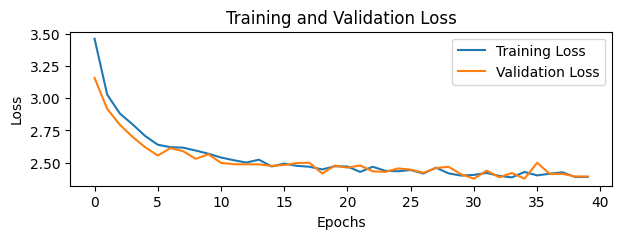

In [20]:
plot_loss(history_br)

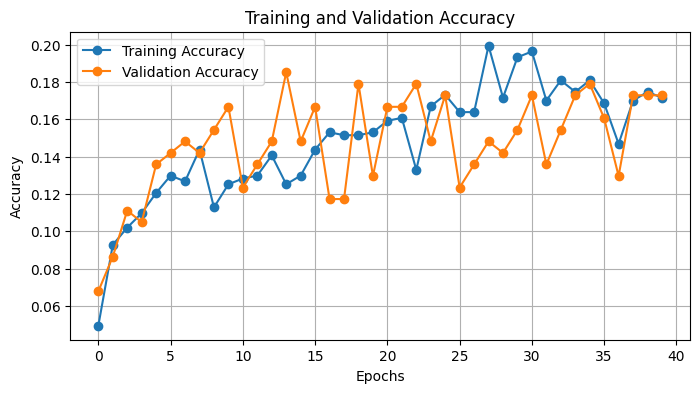

In [21]:
def plot_accuracy(history):
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.grid(True)
    plt.show()

plot_accuracy(history_br)


## 5.4 Keras Image Recognition

### Keras Tuner

In [ ]:
import itertools
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import os

# ─── USER CONFIG ────────────────────────────────────────────────────────────────

# Number of classes in your dataset
NUM_CLASSES = 166

# Maximum number of epochs per trial
MAX_EPOCHS = 50

# ─── HYPERPARAMETER GRID ───────────────────────────────────────────────────────

optimizers_list = ['adam', 'rmsprop', 'sgd']
learning_rates   = [1e-3, 1e-4, 1e-5]
dropouts         = [0.2, 0.3, 0.4, 0.5]
dense_units      = [64, 128, 256]
batch_sizes      = [32]               # you can add more if desired
image_sizes      = [(224, 224)]       # likewise
use_weights      = [True, False]

all_combinations = list(itertools.product(
    optimizers_list, learning_rates, dropouts,
    dense_units, batch_sizes, image_sizes, use_weights
))

# reproducibility
random.seed(4)
np.random.seed(4)
tf.random.set_seed(4)

# sample 50 random hyperparam combinations
sampled_combos = random.sample(all_combinations, k=50)

# ─── RESULTS STORAGE ───────────────────────────────────────────────────────────

results = []

# ─── LOOP OVER CONFIGS ─────────────────────────────────────────────────────────

for i, (opt_name, lr, dropout, units,
         batch_size, image_size, use_wt) in enumerate(sampled_combos, start=1):

    print(f"\n=== Trial {i:02d}/{len(sampled_combos)} ===")
    print(f"opt={opt_name}, lr={lr}, dropout={dropout}, "
          f"units={units}, batch={batch_size}, size={image_size}, "
          f"class_weight={use_wt}")
    # -- clear previous model and data --
    clear_all_caches()

    # -- build model --
    model = models.Sequential([
        layers.Input((*image_size, 3)),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(units, activation='relu'),
        layers.Dropout(dropout),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    # select optimizer
    if opt_name == 'adam':
        opt = optimizers.Adam(learning_rate=lr)
    elif opt_name == 'rmsprop':
        opt = optimizers.RMSprop(learning_rate=lr)
    else:
        opt = optimizers.SGD(learning_rate=lr, momentum=0.9)

    model.compile(
        optimizer=opt,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # compute class weights if requested
    class_weight = None
    if use_wt:
        # gather all labels in train_ds
        y_list = []
        for images, labels in train_ds.unbatch().batch(1024):
            y_list.append(labels.numpy())
        y_all = np.concatenate(y_list, axis=0)

        weights = compute_class_weight(
            class_weight='balanced',
            classes=np.unique(y_all),
            y=y_all
        )
        class_weight = {i: w for i, w in enumerate(weights)}

    # train with early stopping
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=MAX_EPOCHS,
        callbacks=[EarlyStopping(
            patience=10,
            restore_best_weights=True
        )],
        class_weight=class_weight,
        verbose=0
    )

    best_val_acc = max(history.history['val_accuracy'])
    print(f"→ Best val_accuracy: {best_val_acc:.4f}")

    # record results
    results.append({
        'optimizer':   opt_name,
        'lr':          lr,
        'dropout':     dropout,
        'units':       units,
        'batch_size':  batch_size,
        'image_size':  image_size,
        'use_weights': use_wt,
        'val_acc':     best_val_acc
    })

# ─── LEADERBOARD ───────────────────────────────────────────────────────────────

df_results = pd.DataFrame(results)
df_results = df_results.sort_values('val_acc', ascending=False).reset_index(drop=True)

print("\nTop 10 hyperparameter combinations:")
print(df_results.head(10))

# Optionally save to CSV
df_results.to_csv('hyperparam_search_results.csv', index=False)
print("\nFull results saved to hyperparam_search_results.csv")



=== Trial 01/50 ===
opt=adam, lr=1e-05, dropout=0.4, units=64, batch=32, size=(224, 224), class_weight=True
✅ All sessions cleared and garbage collected.


2025-04-30 20:14:51.001847: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
I0000 00:00:1746040493.468608  649185 service.cc:152] XLA service 0x7f0f200060b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746040493.468667  649185 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2025-04-30 20:14:53.541714: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746040493.740171  649185 cuda_dnn.cc:529] Loaded cuDNN version 90800
I0000 00:00:1746040499.187343  649185 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


→ Best val_accuracy: 0.1462

=== Trial 02/50 ===
opt=rmsprop, lr=0.001, dropout=0.2, units=256, batch=32, size=(224, 224), class_weight=False
✅ All sessions cleared and garbage collected.


2025-04-30 20:16:37.731071: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_675', 84 bytes spill stores, 84 bytes spill loads

2025-04-30 20:16:37.981462: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_675', 84 bytes spill stores, 84 bytes spill loads

2025-04-30 20:16:38.001656: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_675', 404 bytes spill stores, 404 bytes spill loads

2025-04-30 20:16:38.291351: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_806', 12 bytes spill stores, 12 bytes spill loads

2025-04-30 20:16:41.544456: I external/loc

→ Best val_accuracy: 0.3923

=== Trial 03/50 ===
opt=adam, lr=0.0001, dropout=0.2, units=128, batch=32, size=(224, 224), class_weight=True
✅ All sessions cleared and garbage collected.


2025-04-30 20:17:43.066652: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-04-30 20:17:49.898004: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_82', 4 bytes spill stores, 4 bytes spill loads



→ Best val_accuracy: 0.3077

=== Trial 04/50 ===
opt=sgd, lr=0.0001, dropout=0.4, units=256, batch=32, size=(224, 224), class_weight=True
✅ All sessions cleared and garbage collected.


2025-04-30 20:18:53.399329: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_765', 28 bytes spill stores, 28 bytes spill loads

2025-04-30 20:18:53.469436: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_765', 24 bytes spill stores, 24 bytes spill loads

2025-04-30 20:18:53.471577: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_765', 8 bytes spill stores, 8 bytes spill loads

2025-04-30 20:18:53.483887: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_765', 24 bytes spill stores, 24 bytes spill loads

2025-04-30 20:18:53.489093: I external/local_x

→ Best val_accuracy: 0.1538

=== Trial 05/50 ===
opt=rmsprop, lr=0.0001, dropout=0.2, units=256, batch=32, size=(224, 224), class_weight=False
✅ All sessions cleared and garbage collected.
→ Best val_accuracy: 0.3231

=== Trial 06/50 ===
opt=rmsprop, lr=1e-05, dropout=0.2, units=128, batch=32, size=(224, 224), class_weight=True
✅ All sessions cleared and garbage collected.


2025-04-30 20:21:45.727838: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


→ Best val_accuracy: 0.1923

=== Trial 07/50 ===
opt=adam, lr=0.0001, dropout=0.4, units=128, batch=32, size=(224, 224), class_weight=False
✅ All sessions cleared and garbage collected.


2025-04-30 20:23:24.710484: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_795', 84 bytes spill stores, 84 bytes spill loads

2025-04-30 20:23:24.828354: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_795', 32 bytes spill stores, 32 bytes spill loads

2025-04-30 20:23:25.115724: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_795', 404 bytes spill stores, 404 bytes spill loads

2025-04-30 20:23:28.673741: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_795', 152 bytes spill stores, 152 bytes spill loads



→ Best val_accuracy: 0.3462

=== Trial 08/50 ===
opt=adam, lr=0.001, dropout=0.5, units=256, batch=32, size=(224, 224), class_weight=False
✅ All sessions cleared and garbage collected.
→ Best val_accuracy: 0.3692

=== Trial 09/50 ===
opt=adam, lr=0.001, dropout=0.4, units=256, batch=32, size=(224, 224), class_weight=False
✅ All sessions cleared and garbage collected.
→ Best val_accuracy: 0.4769

=== Trial 10/50 ===
opt=adam, lr=0.001, dropout=0.2, units=256, batch=32, size=(224, 224), class_weight=False
✅ All sessions cleared and garbage collected.
→ Best val_accuracy: 0.3462

=== Trial 11/50 ===
opt=rmsprop, lr=0.0001, dropout=0.3, units=64, batch=32, size=(224, 224), class_weight=True
✅ All sessions cleared and garbage collected.
→ Best val_accuracy: 0.2462

=== Trial 12/50 ===
opt=rmsprop, lr=1e-05, dropout=0.5, units=128, batch=32, size=(224, 224), class_weight=True
✅ All sessions cleared and garbage collected.
→ Best val_accuracy: 0.1308

=== Trial 13/50 ===
opt=rmsprop, lr=0.001,

2025-04-30 20:32:58.897021: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_758', 24 bytes spill stores, 24 bytes spill loads

2025-04-30 20:32:58.934056: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_758', 24 bytes spill stores, 24 bytes spill loads

2025-04-30 20:32:58.977926: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_758', 8 bytes spill stores, 8 bytes spill loads

2025-04-30 20:32:58.977961: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_758', 24 bytes spill stores, 24 bytes spill loads



→ Best val_accuracy: 0.2615

=== Trial 15/50 ===
opt=adam, lr=0.001, dropout=0.4, units=128, batch=32, size=(224, 224), class_weight=False
✅ All sessions cleared and garbage collected.
→ Best val_accuracy: 0.3923

=== Trial 16/50 ===
opt=adam, lr=1e-05, dropout=0.3, units=128, batch=32, size=(224, 224), class_weight=True
✅ All sessions cleared and garbage collected.


2025-04-30 20:36:13.553796: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


→ Best val_accuracy: 0.2385

=== Trial 17/50 ===
opt=rmsprop, lr=1e-05, dropout=0.4, units=64, batch=32, size=(224, 224), class_weight=False
✅ All sessions cleared and garbage collected.
→ Best val_accuracy: 0.2615

=== Trial 18/50 ===
opt=rmsprop, lr=1e-05, dropout=0.4, units=256, batch=32, size=(224, 224), class_weight=False
✅ All sessions cleared and garbage collected.
→ Best val_accuracy: 0.2692

=== Trial 19/50 ===
opt=rmsprop, lr=0.001, dropout=0.5, units=128, batch=32, size=(224, 224), class_weight=True
✅ All sessions cleared and garbage collected.
→ Best val_accuracy: 0.2923

=== Trial 20/50 ===
opt=adam, lr=1e-05, dropout=0.5, units=256, batch=32, size=(224, 224), class_weight=True
✅ All sessions cleared and garbage collected.
→ Best val_accuracy: 0.3000

=== Trial 21/50 ===
opt=adam, lr=0.0001, dropout=0.5, units=128, batch=32, size=(224, 224), class_weight=True
✅ All sessions cleared and garbage collected.


2025-04-30 20:44:28.865114: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 931.57MiB (rounded to 976819200)requested by op 
2025-04-30 20:44:28.865248: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1058] BFCAllocator dump for GPU_0_bfc
2025-04-30 20:44:28.865261: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1065] Bin (256): 	Total Chunks: 1162, Chunks in use: 1159. 290.5KiB allocated for chunks. 289.8KiB in use in bin. 26.0KiB client-requested in use in bin.
2025-04-30 20:44:28.865266: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1065] Bin (512): 	Total Chunks: 115, Chunks in use: 115. 69.2KiB allocated for chunks. 69.2KiB in use in bin. 63.2KiB client-requested in use in bin.
2025-04-30 20:44:28.865270: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1065] Bin (1024): 	Total Chunks: 34, Chunks in use: 33. 35.5KiB allocated for chunks. 34.2KiB in use in bin. 29.2KiB client-r

ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/timst/DeepLearning2425/.venv/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/timst/DeepLearning2425/.venv/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/timst/DeepLearning2425/.venv/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/timst/DeepLearning2425/.venv/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.12/asyncio/base_events.py", line 641, in run_forever

  File "/usr/lib/python3.12/asyncio/base_events.py", line 1987, in _run_once

  File "/usr/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/home/timst/DeepLearning2425/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/timst/DeepLearning2425/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/timst/DeepLearning2425/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/timst/DeepLearning2425/.venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/timst/DeepLearning2425/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/timst/DeepLearning2425/.venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/timst/DeepLearning2425/.venv/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/timst/DeepLearning2425/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3098, in run_cell

  File "/home/timst/DeepLearning2425/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3153, in _run_cell

  File "/home/timst/DeepLearning2425/.venv/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/timst/DeepLearning2425/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3362, in run_cell_async

  File "/home/timst/DeepLearning2425/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3607, in run_ast_nodes

  File "/home/timst/DeepLearning2425/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3667, in run_code

  File "/tmp/ipykernel_648992/2254872891.py", line 104, in <module>

  File "/home/timst/DeepLearning2425/.venv/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/timst/DeepLearning2425/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/home/timst/DeepLearning2425/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/home/timst/DeepLearning2425/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

Out of memory while trying to allocate 976819080 bytes.
	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_multi_step_on_iterator_150346]

In [ ]:
import kerastuner as kt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers

def build_hypermodel(hp):
    # hyperparameters we’ll tune:
    init_filters = hp.Choice('init_filters', [32, 64, 128])
    block1 = hp.Choice('block1_filters', [128, 256])
    block2 = hp.Choice('block2_filters', [256, 512])
    block3 = hp.Choice('block3_filters', [512, 728])
    # dropout_rate = hp.Float('dropout', 0.0, 0.5, step=0.1)
    #  learning_rate = hp.Float('lr', 1e-5, 1e-3, sampling='log')
    
    inputs = keras.Input(shape=(224,224,3))
    x = layers.Rescaling(1./255)(inputs)
    # initial Conv
    x = layers.Conv2D(init_filters, 3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    prev = x
    
    # three residual blocks
    for size in [block1, block2, block3]:
        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(size, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(size, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D(3, strides=2, padding='same')(x)
        
        # residual projection
        res = layers.Conv2D(size, 1, strides=2, padding='same')(prev)
        x = layers.add([x, res])
        prev = x
    
    x = layers.SeparableConv2D(1024, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(
        13,              # or pass num_classes dynamically
        activation='softmax'
    )(x)
    
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# instantiate tuner
tuner = kt.RandomSearch(
    build_hypermodel,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=1,
    overwrite=True
)

# run search (assuming you have tf.data datasets train_ds, val_ds):
tuner.search(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[keras.callbacks.EarlyStopping(patience=5)]
)

# inspect best
best = tuner.get_best_hyperparameters(1)[0]
print("Best init_filters:", best.get('init_filters'))
print("Best block filters:", best.get('block1_filters'),
                            best.get('block2_filters'),
                            best.get('block3_filters'))
print("Best dropout:", best.get('dropout'))
print("Best lr:", best.get('lr'))

# retrieve model and train to convergence
model = tuner.hypermodel.build(best)
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)


Trial 4 Complete [00h 00m 24s]

Best val_accuracy So Far: 0.26153847575187683
Total elapsed time: 00h 02m 04s

Search: Running Trial #5

Value             |Best Value So Far |Hyperparameter
64                |32                |init_filters
256               |128               |block1_filters
256               |256               |block2_filters
512               |512               |block3_filters

Epoch 1/10


2025-04-25 10:27:12.886682: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.43GiB (rounded to 3684254208)requested by op 
2025-04-25 10:27:12.886750: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1058] BFCAllocator dump for GPU_0_bfc
2025-04-25 10:27:12.886761: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1065] Bin (256): 	Total Chunks: 1183, Chunks in use: 1183. 295.8KiB allocated for chunks. 295.8KiB in use in bin. 11.6KiB client-requested in use in bin.
2025-04-25 10:27:12.886765: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1065] Bin (512): 	Total Chunks: 89, Chunks in use: 89. 45.2KiB allocated for chunks. 45.2KiB in use in bin. 44.5KiB client-requested in use in bin.
2025-04-25 10:27:12.886768: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1065] Bin (1024): 	Total Chunks: 112, Chunks in use: 112. 120.8KiB allocated for chunks. 120.8KiB in use in bin. 114.0KiB client

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "/home/timst/DeepLearning2425/.venv/lib/python3.12/site-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/home/timst/DeepLearning2425/.venv/lib/python3.12/site-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/timst/DeepLearning2425/.venv/lib/python3.12/site-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/timst/DeepLearning2425/.venv/lib/python3.12/site-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/timst/DeepLearning2425/.venv/lib/python3.12/site-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/timst/DeepLearning2425/.venv/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/timst/DeepLearning2425/.venv/lib/python3.12/site-packages/tensorflow/python/eager/execute.py", line 59, in quick_execute
    except TypeError as e:
tensorflow.python.framework.errors_impl.ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/timst/DeepLearning2425/.venv/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/timst/DeepLearning2425/.venv/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/timst/DeepLearning2425/.venv/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/timst/DeepLearning2425/.venv/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.12/asyncio/base_events.py", line 641, in run_forever

  File "/usr/lib/python3.12/asyncio/base_events.py", line 1987, in _run_once

  File "/usr/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/home/timst/DeepLearning2425/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/timst/DeepLearning2425/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/timst/DeepLearning2425/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/timst/DeepLearning2425/.venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/timst/DeepLearning2425/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/timst/DeepLearning2425/.venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/timst/DeepLearning2425/.venv/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/timst/DeepLearning2425/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3098, in run_cell

  File "/home/timst/DeepLearning2425/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3153, in _run_cell

  File "/home/timst/DeepLearning2425/.venv/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/timst/DeepLearning2425/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3362, in run_cell_async

  File "/home/timst/DeepLearning2425/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3607, in run_ast_nodes

  File "/home/timst/DeepLearning2425/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3667, in run_code

  File "/tmp/ipykernel_325989/3697151790.py", line 67, in <module>

  File "/home/timst/DeepLearning2425/.venv/lib/python3.12/site-packages/keras_tuner/src/engine/base_tuner.py", line 234, in search

  File "/home/timst/DeepLearning2425/.venv/lib/python3.12/site-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial

  File "/home/timst/DeepLearning2425/.venv/lib/python3.12/site-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial

  File "/home/timst/DeepLearning2425/.venv/lib/python3.12/site-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial

  File "/home/timst/DeepLearning2425/.venv/lib/python3.12/site-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model

  File "/home/timst/DeepLearning2425/.venv/lib/python3.12/site-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit

  File "/home/timst/DeepLearning2425/.venv/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/timst/DeepLearning2425/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/home/timst/DeepLearning2425/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/home/timst/DeepLearning2425/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

Out of memory while trying to allocate 3684254168 bytes.
	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_multi_step_on_iterator_97242]


## Final Model

In [ ]:
# Best Hyperparameters from Keras Tuner
lr=0.001
dropout=0.4
units=256
batch=32
size=(224, 224)
class_weight=False

In [ ]:
# --- build the model ---
model = models.Sequential([
        layers.Input((*size, 3)),
        layers.Conv2D(32, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(units, activation='relu'),
        layers.Dropout(dropout),
        layers.Dense(13, activation='softmax')
])


In [ ]:
# import keras

# def make_model(input_shape, num_classes):
#     inputs = keras.Input(shape=input_shape)

#     # Entry block
#     x = layers.Rescaling(1.0 / 255)(inputs)
#     x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation("relu")(x)

#     previous_block_activation = x  # Set aside residual

#     for size in [256, 512, 728]:
#         x = layers.Activation("relu")(x)
#         x = layers.SeparableConv2D(size, 3, padding="same")(x)
#         x = layers.BatchNormalization()(x)

#         x = layers.Activation("relu")(x)
#         x = layers.SeparableConv2D(size, 3, padding="same")(x)
#         x = layers.BatchNormalization()(x)

#         x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

#         # Project residual
#         residual = layers.Conv2D(size, 1, strides=2, padding="same")(
#             previous_block_activation
#         )
#         x = layers.add([x, residual])  # Add back residual
#         previous_block_activation = x  # Set aside next residual

#     x = layers.SeparableConv2D(1024, 3, padding="same")(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation("relu")(x)

#     x = layers.GlobalAveragePooling2D()(x)
#     if num_classes == 2:
#         units = 1
#     else:
#         units = num_classes

#     x = layers.Dropout(0.25)(x)
#     # We specify activation=None so as to return logits
#     outputs = layers.Dense(units, activation=None)(x)
#     return keras.Model(inputs, outputs)


# model = make_model(input_shape=(224, 224, 3), num_classes=13)

In [ ]:
# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr), 
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

#callbacks
checkpoint = ModelCheckpoint(
    "models/cnidaria_models/best_custom.keras",
    monitor='val_accuracy',
    mode = 'max',
    save_best_only=True,
    verbose=1
)

callbacks = [
  #EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
  #ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
  checkpoint
]

history_kerasImage = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=50,           # Start small, increase if needed
        verbose=1,
        callbacks=callbacks,
    )

Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.1646 - loss: 5.4301
Epoch 1: val_accuracy improved from -inf to 0.26154, saving model to models/cnidaria_models/best_custom.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 359ms/step - accuracy: 0.1671 - loss: 5.3432 - val_accuracy: 0.2615 - val_loss: 2.3925
Epoch 2/50
15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2651 - loss: 2.4181
Epoch 2: val_accuracy did not improve from 0.26154
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.2616 - loss: 2.4145 - val_accuracy: 0.2615 - val_loss: 2.3052
Epoch 3/50
15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2551 - loss: 2.2903
Epoch 3: val_accuracy did not improve from 0.26154
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.2508 - loss: 2.2992 - val_accuracy: 0.2615 - val_loss: 2.2894
Epoch 4/50
15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2269 - loss: 2.3471
Epoch 4: val_accuracy did not improve from 0.26154
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accu

### Results visualization

In [ ]:
def plot_loss(history):
    """
    Plot the training and validation loss over epochs.

    Parameters:
    - history: History object returned by model.fit() containing training/validation loss values.

    Returns:
    - None (displays a plot of training and validation loss)
    """
    plt.figure(figsize=(7, 2))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()


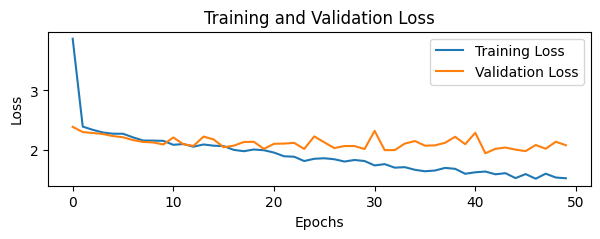

In [ ]:
plot_loss(history_kerasImage)

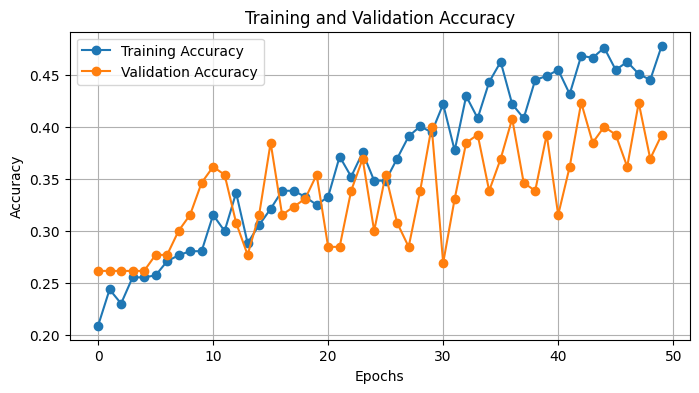

In [ ]:
def plot_accuracy(history):
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.grid(True)
    plt.show()

plot_accuracy(history_kerasImage)